# 02 — SUSY Signal Regions (CMS Derived ROOT: DY/WJets/TT vs SMS‑TChiWZ)

This notebook continues the previous EDA, focusing on *signal-like* selections.
We load CMS-derived ROOT features for DY, WJets, TT (background) and SMS‑TChiWZ_ZToLL (signal), apply baseline + physics cleaning, and define control/signal regions for fast validation plots.


## Quick validation checklist (pass/fail)

Before moving to training, confirm:

1) Inputs loaded:
- DY/WJets/TT/SUSY have non-zero rows
- ROOT tree name is detected (typically `Events`)

2) Cleaning is sensible:
- Event counts decrease only where expected (outliers/trivial events)

3) Regions are populated:
- Baseline has enough statistics
- Signal and control regions are both non-empty

4) Plot sanity:
- `signal_vs_control_met.jpg` is produced and shows a harder MET tail in the signal region by construction.


In [1]:
# Cell 1 — Install deps (no XRootD needed)
!pip -q install "uproot>=5" awkward vector rich tqdm pandas pyarrow fastparquet matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 393.8/393.8 kB 8.8 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 919.6/919.6 kB 29.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 656.7/656.7 kB 37.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 181.2/181.2 kB 13.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 57.4 MB/s eta 0:00:00


In [17]:
import uproot
import pandas as pd
import numpy as np
import glob
import matplotlib.pyplot as plt


## 1) Feature schema

We use a fixed list of ~50 engineered observables spanning:
- Object multiplicities (`nMuon`, `nElectron`, `nJet`, `nJet_pt30`)
- MET (`MET_pt`, `MET_phi`, `MET_sumEt`)
- Leading muon/electron/jet kinematics (pt/eta/phi for indices 0–3 where applicable)
- Event summaries (`HT`, `ST`)
- Dilepton/dijet masses (`M_ll`, `M_jj_01`, `M_jj_12`)
- Angular variables (`delta_phi_*`, `delta_R_*`)
- b-tag scores (`Jet_btagDeepB_0/1`)
- Ratios (`HT_ratio`, `MET_pt_HT_ratio`)


In [3]:
FEATURES = [
"nMuon","nElectron","nJet","MET_pt","MET_phi","MET_sumEt",
"Muon_pt_0","Muon_eta_0","Muon_phi_0",
"Muon_pt_1","Muon_eta_1","Muon_phi_1",
"Electron_pt_0","Electron_eta_0","Electron_phi_0",
"Electron_pt_1","Electron_eta_1","Electron_phi_1",
"Jet_pt_0","Jet_eta_0","Jet_phi_0",
"Jet_pt_1","Jet_eta_1","Jet_phi_1",
"Jet_pt_2","Jet_eta_2","Jet_phi_2",
"Jet_pt_3","Jet_eta_3","Jet_phi_3",
"HT","ST","M_ll","M_jj_01","M_jj_12",
"delta_phi_MET_j0","delta_phi_MET_j1","min_delta_phi_MET_jets",
"delta_R_j0_j1","delta_phi_ll","delta_R_ll",
"Jet_btagDeepB_0","Jet_btagDeepB_1",
"MT_lep_MET","HT_ratio","MET_pt_HT_ratio",
"nJet_pt30","Jet_mass_0","LeadLepton_pt","sum_pt_leptons"
]


## 2) Loading approach (fast + robust)

We read ROOT files with `uproot` and:
1. Recursively find the first available TTree in each file (usually `Events`)
2. Iterate in chunks (`step_size`) to control memory
3. Convert each batch to pandas and append `label` + `source`
4. Concatenate into a single dataframe for cleaning + selections

We cap `max_files` during development; increase it once plots and selections look stable.


In [4]:
import uproot, pandas as pd, glob, gc
import pyarrow as pa
import pyarrow.parquet as pq

def stream_folder_to_parquet(
        folder,
        out_path,
        label,
        source,
        step_size=50000):

    files = sorted(glob.glob(folder+"/*.root"))

    print(f"\nStreaming {source} from {len(files)} files")

    writer = None
    total = 0

    for i, f in enumerate(files):

        print(f"File {i+1}/{len(files)}")

        with uproot.open(f) as file:

            tree = None

            # detect tree automatically
            for key, obj in file.items(recursive=True):
                if isinstance(obj, uproot.behaviors.TTree.TTree):
                    tree = obj
                    break

            if tree is None:
                print("   No tree → skip")
                continue

            print("   Tree:", tree.name)

            for batch in tree.iterate(FEATURES, library="pd", step_size=step_size):

                batch["label"] = label
                batch["source"] = source

                table = pa.Table.from_pandas(batch)

                if writer is None:
                    writer = pq.ParquetWriter(out_path, table.schema)

                writer.write_table(table)

                total += len(batch)

                # free memory
                del batch
                gc.collect()

    if writer:
        writer.close()

    print(f"Saved {total} events → {out_path}")

In [5]:
import uproot, pandas as pd, glob, gc, awkward as ak
import pyarrow as pa
import pyarrow.parquet as pq

def stream_real_rntuple(folder, out_path, step_size=50000):

    files = sorted(glob.glob(folder+"/*.root"))[45:]
    print(f"\nStreaming REAL (RNTuple) from {len(files)} files")

    writer = None
    total = 0

    for i, f in enumerate(files):

        print(f"File {i+1}/{len(files)}")

        with uproot.open(f) as file:

            if "Features" not in file:
                print("   Features not found → skip")
                continue

            ntuple = file["Features"]
            print("   Found RNTuple")

            # iterate batches as awkward arrays
            for batch in ntuple.iterate(step_size=step_size):

                # convert awkward → pandas safely
                batch = ak.to_dataframe(batch).reset_index(drop=True)

                # keep only feature columns
                batch = batch[FEATURES]

                batch["label"] = -1
                batch["source"] = "REAL"

                table = pa.Table.from_pandas(batch)

                if writer is None:
                    writer = pq.ParquetWriter(out_path, table.schema)

                writer.write_table(table)

                total += len(batch)

                del batch
                gc.collect()

    if writer:
        writer.close()

    print(f"Saved {total} REAL events → {out_path}")

In [6]:
import glob

base_real = "/kaggle/input/datasets/hiteshrs/cms2016g29-5785/processed_events"

files = sorted(glob.glob(base_real+"/*.root"))

print("Number of files:", len(files))
print("Example file:", files[0])

Number of files: 85
Example file: /kaggle/input/datasets/hiteshrs/cms2016g29-5785/processed_events/DerivedFeatures(1).root


In [7]:
import uproot

with uproot.open(files[0]) as f:

    print("=== KEYS (recursive) ===")
    print(f.keys(recursive=True))

    print("\n=== CLASSNAMES ===")
    print(f.classnames(recursive=True))

=== KEYS (recursive) ===
['Features;1']

=== CLASSNAMES ===
{'Features;1': 'ROOT::RNTuple'}


In [8]:
with uproot.open(files[0]) as f:

    print("\n=== OBJECT TYPES ===")

    for key, obj in f.items(recursive=True):
        print(key, "->", type(obj))


=== OBJECT TYPES ===
Features;1 -> <class 'uproot.models.RNTuple.Model_ROOT_3a3a_RNTuple'>


In [9]:
with uproot.open(files[0]) as f:
    tree = f["Features"]
    print(tree)
    print(tree.keys())

<ROOT::RNTuple 'Features' (52 fields) at 0x7a1ed0568920>
['Electron_eta_0', 'Electron_eta_1', 'Electron_phi_0', 'Electron_phi_1', 'Electron_pt_0', 'Electron_pt_1', 'HT', 'HT_ratio', 'Jet_btagDeepB_0', 'Jet_btagDeepB_1', 'Jet_eta_0', 'Jet_eta_1', 'Jet_eta_2', 'Jet_eta_3', 'Jet_mass_0', 'Jet_phi_0', 'Jet_phi_1', 'Jet_phi_2', 'Jet_phi_3', 'Jet_pt_0', 'Jet_pt_1', 'Jet_pt_2', 'Jet_pt_3', 'LeadLepton_pt', 'MET_phi', 'MET_pt', 'MET_pt_HT_ratio', 'MET_sumEt', 'MT_lep_MET', 'M_jj_01', 'M_jj_12', 'M_ll', 'Muon_eta_0', 'Muon_eta_1', 'Muon_phi_0', 'Muon_phi_1', 'Muon_pt_0', 'Muon_pt_1', 'ST', 'delta_R_j0_j1', 'delta_R_ll', 'delta_phi_MET_j0', 'delta_phi_MET_j1', 'delta_phi_ll', 'luminosityBlock', 'min_delta_phi_MET_jets', 'nElectron', 'nJet', 'nJet_pt30', 'nMuon', 'run', 'sum_pt_leptons']


## 3) Inputs

MC/SUSY (derived features, ROOT):
- `/kaggle/input/datasets/katakuricharlotte/cms-derivedroot/derivedroot/`
  - DYJetsToLL_0J_TuneCP5
  - WJetsToLNu_TuneCP5
  - TTJets_TuneCP5
  - SMS-TChiWZ_ZToLL

Optional real-data cross-check:
- `/kaggle/input/datasets/hiteshrs/cms2016g29-5785/processed_events`

Notes:
- If REAL loads as “0 files / No data loaded”, we treat it as unavailable and proceed with MC-only training tables.


In [10]:
base_mc = "/kaggle/input/datasets/katakuricharlotte/cms-derivedroot/derivedroot"
base_real = "/kaggle/input/datasets/hiteshrs/cms2016g29-5785/processed_events"

# MC
stream_folder_to_parquet(f"{base_mc}/DYJetsToLL_0J_TuneCP5", "/kaggle/working/dy.parquet", 0, "DY")
stream_folder_to_parquet(f"{base_mc}/WJetsToLNu_TuneCP5", "/kaggle/working/wjets.parquet", 0, "WJets")
stream_folder_to_parquet(f"{base_mc}/TTJets_TuneCP5", "/kaggle/working/tt.parquet", 0, "TT")
stream_folder_to_parquet(f"{base_mc}/SMS-TChiWZ_ZToLL", "/kaggle/working/susy.parquet", 1, "SUSY")

# REAL (RNTuple)
stream_real_rntuple(base_real, "/kaggle/working/real.parquet")


Streaming DY from 4 files
File 1/4
   Tree: Events
File 2/4
   Tree: Events
File 3/4
   Tree: Events
File 4/4
   Tree: Events
Saved 6063865 events → /kaggle/working/dy.parquet

Streaming WJets from 4 files
File 1/4
   Tree: Events
File 2/4
   Tree: Events
File 3/4
   Tree: Events
File 4/4
   Tree: Events
Saved 5407002 events → /kaggle/working/wjets.parquet

Streaming TT from 4 files
File 1/4
   Tree: Events
File 2/4
   Tree: Events
File 3/4
   Tree: Events
File 4/4
   Tree: Events
Saved 3145070 events → /kaggle/working/tt.parquet

Streaming SUSY from 4 files
File 1/4
   Tree: Events
File 2/4
   Tree: Events
File 3/4
   Tree: Events
File 4/4
   Tree: Events
Saved 7827023 events → /kaggle/working/susy.parquet

Streaming REAL (RNTuple) from 40 files
File 1/40
   Found RNTuple
File 2/40
   Found RNTuple
File 3/40
   Found RNTuple
File 4/40
   Found RNTuple
File 5/40
   Found RNTuple
File 6/40
   Found RNTuple
File 7/40
   Found RNTuple
File 8/40
   Found RNTuple
File 9/40
   Found RNTuple

In [11]:
stream_real_rntuple(
    "/kaggle/input/datasets/hiteshrs/cms2016g29-5785/processed_events",
    "/kaggle/working/real.parquet"
)


Streaming REAL (RNTuple) from 40 files
File 1/40
   Found RNTuple
File 2/40
   Found RNTuple
File 3/40
   Found RNTuple
File 4/40
   Found RNTuple
File 5/40
   Found RNTuple
File 6/40
   Found RNTuple
File 7/40
   Found RNTuple
File 8/40
   Found RNTuple
File 9/40
   Found RNTuple
File 10/40
   Found RNTuple
File 11/40
   Found RNTuple
File 12/40
   Found RNTuple
File 13/40
   Found RNTuple
File 14/40
   Found RNTuple
File 15/40
   Found RNTuple
File 16/40
   Found RNTuple
File 17/40
   Found RNTuple
File 18/40
   Found RNTuple
File 19/40
   Found RNTuple
File 20/40
   Found RNTuple
File 21/40
   Found RNTuple
File 22/40
   Found RNTuple
File 23/40
   Found RNTuple
File 24/40
   Found RNTuple
File 25/40
   Found RNTuple
File 26/40
   Found RNTuple
File 27/40
   Found RNTuple
File 28/40
   Found RNTuple
File 29/40
   Found RNTuple
File 30/40
   Found RNTuple
File 31/40
   Found RNTuple
File 32/40
   Found RNTuple
File 33/40
   Found RNTuple
File 34/40
   Found RNTuple
File 35/40
   Fou

In [12]:
paths = {
    "DY": "/kaggle/working/dy.parquet",
    "WJets": "/kaggle/working/wjets.parquet",
    "TT": "/kaggle/working/tt.parquet",
    "SUSY": "/kaggle/working/susy.parquet",
    "REAL": "/kaggle/working/real.parquet"
}

In [13]:
import pyarrow.parquet as pq

def stream_parquet(path, batch_size=200000):
    pf = pq.ParquetFile(path)
    for batch in pf.iter_batches(batch_size=batch_size):
        yield batch.to_pandas()

## 4) Cleaning and selections

Cleaning steps:
- Replace ±inf → NaN, drop NaNs
- Apply detector-realism bounds (e.g., MET and leading object pt upper caps)
- Apply eta acceptance (|eta| < 5 for all *_eta_* columns)
- Remove trivial events (require at least one jet or lepton)

Region definitions:
- Baseline: `MET_pt > 50`, `nJet >= 2`, `HT > 200`, `LeadLepton_pt > 20`
- Signal region: `MET_pt > 200`, `HT > 400`, `nJet >= 3`
- Control region: `MET_pt < 100`, `HT < 300`

Outputs:
- Diagnostic counts after each stage
- A first validation plot comparing MET in control vs signal region (log-y), saved to `/kaggle/working/`.


In [14]:
import numpy as np

def clean_dataframe(df):

    df = df.replace([np.inf, -np.inf], np.nan).dropna()

    df = df[
        (df["MET_pt"] < 2000) &
        (df["Jet_pt_0"] < 3000) &
        (df["Muon_pt_0"] < 2000) &
        (df["Electron_pt_0"] < 2000)
    ]

    eta_cols = [c for c in df.columns if "_eta_" in c]
    for c in eta_cols:
        df = df[df[c].abs() < 5]

    df = df[
        (df["nJet"] > 0) |
        (df["nMuon"] > 0) |
        (df["nElectron"] > 0)
    ]

    return df

In [15]:
def baseline_sel(df):
    return df[
        (df["MET_pt"] > 50) &
        (df["nJet"] >= 2) &
        (df["HT"] > 200) &
        (df["LeadLepton_pt"] > 20)
    ]

def signal_sel(df):
    return df[
        (df["MET_pt"] > 200) &
        (df["HT"] > 400) &
        (df["nJet"] >= 3)
    ]

def control_sel(df):
    return df[
        (df["MET_pt"] < 100) &
        (df["HT"] < 300)
    ]

In [18]:
import gc

datasets = {}
stats = {}

for name, path in paths.items():

    print(f"\nProcessing {name}")

    total_initial = 0
    total_cleaned = 0
    total_baseline = 0
    total_signal = 0
    total_control = 0

    baseline_parts = []
    signal_parts = []
    control_parts = []

    for chunk in stream_parquet(path):

        total_initial += len(chunk)

        # ---- CLEAN ----
        chunk = clean_dataframe(chunk)
        total_cleaned += len(chunk)

        # ---- BASELINE ----
        baseline = baseline_sel(chunk)
        total_baseline += len(baseline)

        # ---- SIGNAL ----
        signal = signal_sel(baseline)
        total_signal += len(signal)

        # ---- CONTROL ----
        control = control_sel(baseline)
        total_control += len(control)

        # keep only small subsets (optional)
        if len(baseline) > 0:
            baseline_parts.append(baseline.sample(min(20000, len(baseline))))
        if len(signal) > 0:
            signal_parts.append(signal.sample(min(10000, len(signal))))
        if len(control) > 0:
            control_parts.append(control.sample(min(10000, len(control))))

        # free memory
        del chunk, baseline, signal, control
        gc.collect()

    # merge small subsets only
    datasets[name] = {
        "baseline": pd.concat(baseline_parts, ignore_index=True) if baseline_parts else pd.DataFrame(),
        "signal": pd.concat(signal_parts, ignore_index=True) if signal_parts else pd.DataFrame(),
        "control": pd.concat(control_parts, ignore_index=True) if control_parts else pd.DataFrame()
    }

    stats[name] = {
        "initial": total_initial,
        "cleaned": total_cleaned,
        "baseline": total_baseline,
        "signal": total_signal,
        "control": total_control
    }

    print(stats[name])


Processing DY
{'initial': 6063865, 'cleaned': 5838613, 'baseline': 2129, 'signal': 10, 'control': 1580}

Processing WJets
{'initial': 5407002, 'cleaned': 5125580, 'baseline': 57732, 'signal': 1289, 'control': 26503}

Processing TT
{'initial': 3145070, 'cleaned': 3141468, 'baseline': 880649, 'signal': 26695, 'control': 171319}

Processing SUSY
{'initial': 7827023, 'cleaned': 7338389, 'baseline': 329506, 'signal': 87799, 'control': 31308}

Processing REAL
{'initial': 79040103, 'cleaned': 78669183, 'baseline': 9331801, 'signal': 86317, 'control': 130453}


In [19]:
import pandas as pd
pd.DataFrame(stats).T

,initial,cleaned,baseline,signal,control
DY,6063865,5838613,2129,10,1580
WJets,5407002,5125580,57732,1289,26503
TT,3145070,3141468,880649,26695,171319
SUSY,7827023,7338389,329506,87799,31308
REAL,79040103,78669183,9331801,86317,130453


In [21]:
def paper_axes(ax):
    ax.grid(True, which="both", alpha=0.2)
    ax.tick_params(direction="in", which="both", top=True, right=True)
    return ax


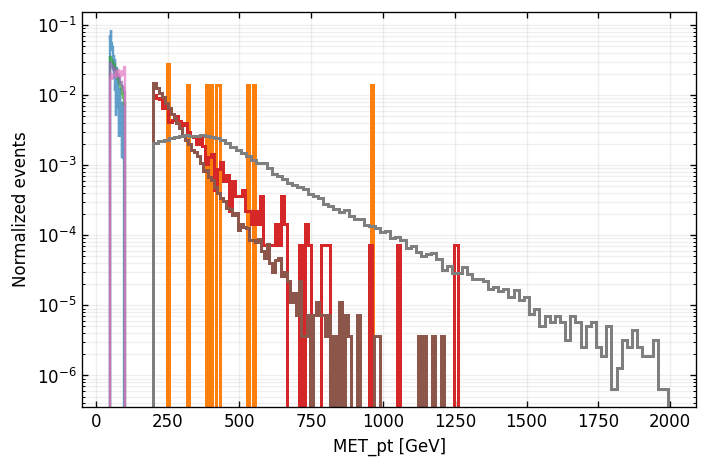

In [22]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(6,4), dpi=120)

for name in ["DY","WJets","TT","SUSY"]:

    sig = datasets[name]["signal"]
    ctrl = datasets[name]["control"]

    if len(ctrl):
        ax.hist(ctrl["MET_pt"], bins=100, histtype="step",
                density=True, linewidth=1.4, alpha=0.7)

    if len(sig):
        ax.hist(sig["MET_pt"], bins=100, histtype="step",
                density=True, linewidth=1.8)

ax.set_yscale("log")
ax.set_xlabel("MET_pt [GeV]")
ax.set_ylabel("Normalized events")

paper_axes(ax)
fig.tight_layout()
plt.show()

In [23]:
train_parts = []

for name in ["DY","WJets","TT","SUSY"]:
    base = datasets[name]["baseline"]
    if len(base):
        train_parts.append(base)

train_df = pd.concat(train_parts, ignore_index=True)

X = train_df.drop(columns=["label","source"])
y = train_df["label"]

print("Training events:", len(X))

Training events: 709367


## 6) Next step (modeling-ready table)

For training:
- Use `baseline` events
- Exclude REAL rows (`label != -1`)
- Define `X = features` and `y = label`

This produces a clean binary classification table (background vs SUSY) ready for a baseline model.
